In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 3.0 建立命名實體識別器
### ~(NVIDIA NeMo v1.0)~ 使用 pytorch

---

在此學習筆記中，您將建立可在醫療疾病摘要中尋找疾病名稱的 NER (命名實體識別) 應用程式。模型不會從清單中「搜尋」名稱，而是根據語言的背景資訊「識別」與疾病相關的特定詞彙。

**[3.1 從命令列分類標記](#3.1-從命令列分類標記)**<br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.1.1 資料輸入](#3.1.1-資料輸入)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.1.1.1 IOB 標記](#3.1.1.1-IOB-標記)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.1.2 設定檔](#3.1.2-設定檔)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.1.3 Hydra 支援的 Python 指令碼](#3.1.3-Hydra-支援的-Python-指令碼)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.1.4 練習：訓練模型](#3.1.4-練習：訓練模型)<br>
**[3.2 特定領域訓練](#3.2-特定領域訓練)**<br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.2.1 使用 TensorBoard 將結果視覺化](#3.2.1-使用-TensorBoard-將結果視覺化)<br>
**[3.3 評估](#3.3-評估)**<br>
**[3.4 推論](#3.4-推論)**<br>

在命名實體識別工作中，您將採用與文字分類工作相同的基本步驟來建立、訓練和測試專案。然而，這一次您將會在 *特定領域* 的 BioMegatron 語言模型上訓練分類器。BioMegatron 是類似 [BERT](https://arxiv.org/abs/1810.04805) 的 [Megatron-LM](https://arxiv.org/pdf/1909.08053.pdf) 模型，已在大型生物醫學文字語料庫進行預先訓練 ([PubMed](https://pubmed.ncbi.nlm.nih.gov/) 摘要和商業用途文集的全文)。我們可以獲得比一般語言模型更好的效能，因為我們的疾病資料集來自相同的生物醫學領域。

也有其他模型可以替代 BioMegatron，其中最著名的是 [BioBERT](https://arxiv.org/abs/1901.08746)。BioMegatron 與 BioBERT 相比，模型規模較大，而且已經在較大的文字語料庫進行預先訓練。

---
# 3.1 從命令列分類標記
我們想回答的問題是：

**在醫療摘要句子中，提到了哪些疾病？**<br>

回顧 NeMo 提供的自然語言處理模型：

因為我們在「標記」層級分類，所以會使用 [標記分類](https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/nlp/token_classification.html) 模型來進行命名實體識別，在此案例中是分類與疾病相關的詞彙。

## 3.1.1 資料輸入
正如我們在 [1.0 探索資料](010_ExploreData.ipynb) 學習筆記中看到的，命名實體識別專案的資料集是由 IOB 標記疾病名稱的句子所組成，句子中的每個詞彙都會標記為在命名實體的內部、外部或開頭。

訓練文字和標籤檔案分別是 `text_train.txt` 和 `labels_train.txt`。驗證和測試檔案也採用類似的命名模式。請確認資料檔案的位置。

In [2]:
# 安裝必要套件
!pip install transformers
!pip install seqeval        # 要評估每個字的正確與否

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=3d1342abe2f1602d83022eddd73fe037800cb01e23c30fa323e301f767f71fec
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [3]:
# 請上傳 NCBI_ner-3.zip, 並解開
!unzip NCBI_ner-3.zip

unzip:  cannot find or open NCBI_ner-3.zip, NCBI_ner-3.zip.zip or NCBI_ner-3.zip.ZIP.


In [4]:
NER3_DATA_DIR = 'NCBI_ner-3'
!ls -lh $NER3_DATA_DIR

ls: cannot access 'NCBI_ner-3': No such file or directory


In [5]:
# Take a look at the data
print("*****\ntext_test.txt sample\n*****")
!head -n 3 $NER3_DATA_DIR/text_test.txt
print("\n*****\nlabels_test.txt sample\n*****")
!head -n 3 $NER3_DATA_DIR/labels_test.txt

*****
text_test.txt sample
*****
head: cannot open 'NCBI_ner-3/text_test.txt' for reading: No such file or directory

*****
labels_test.txt sample
*****
head: cannot open 'NCBI_ner-3/labels_test.txt' for reading: No such file or directory


### 3.1.1.1 IOB 標記
回想一下，命名實體識別資料集中的句子和標籤會使用 _inside (內部)、outside (外部)、beginning (開頭) (IOB)_ 標籤來互相對應。
此機制一般可用於多個命名實體類型：
* B-{CHUNK_TYPE}：開頭區塊中的詞彙
* I-{CHUNK_TYPE}：區塊內的詞彙
* O：區塊外的詞彙

在我們的案例中，我們只會尋找作為實體 (或區塊) 類型的「疾病」，因此我們不需要辨識 I、O 和 B 三種類別之外的內容。
**三種類別**
* B：疾病名稱的開頭
* I：疾病名稱的內部詞彙
* O：所有疾病名稱之外的詞彙

```text
Identification of APC2 , a homologue of the adenomatous polyposis coli tumour suppressor .
O              O  O    O O O         O  O   B           I         I    I      O          O  
```

以上內容定義在 `labels.csv` 檔案中：

In [6]:
!head $NER3_DATA_DIR/label_ids.csv

head: cannot open 'NCBI_ner-3/label_ids.csv' for reading: No such file or directory


如果要尋找兩種命名實體，例如詞性分析中的名詞和動詞，我們會使用五種類別的 IOB 模式：<br>
**五種類別**
* B-N：名詞或名詞片語的開頭
* I-N：名詞或名詞片語的內容
* B-V：動詞或動詞片語的開頭
* I-V：動詞或動詞片語的內容
* O：所有名詞和動詞之外的詞彙

若您有興趣深入瞭解，請參閱與本主題相關的 [這篇論文](http://cs229.stanford.edu/proj2005/KrishnanGanapathy-NamedEntityRecognition.pdf)。

---
Maty note: 詞性分析，需要定義、及標註更多類別

NCBI_ner-3 疾病資料已如 [文件](https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/nlp/token_classification.html#data-input-for-token-classification-model) 所述以正確的格式進行標記分類，因此我們可接著查看設定檔。

In [7]:
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizerFast, BertModel    #
from transformers import BertForTokenClassification         # 偶爾也得偷個懶，反正 transformers 套件已經提供 token 分類了～

USE_PRETRAINED = 'bert-base-uncased'    #'bert-base-uncased'



In [9]:
#$NER3_DATA_DIR/
#df_train = pd.read_csv(NER3_DATA_DIR+ "/train.tsv", encoding='unicode_escape', sep='\t')
#df_train.head()
#df_val = pd.read_csv(NER3_DATA_DIR+ "/dev.tsv", encoding='unicode_escape', sep='\t')
#df_val.head()
#df_test = pd.read_csv(NER3_DATA_DIR+ "/test.tsv", encoding='unicode_escape', sep='\t')
#df_test.head()

#### define function to create dataset
def GetDatasetDF(text_set, label_set, col_names):
    df_ret = pd.DataFrame()
    with open('/content/drive/MyDrive/Colab Notebooks/人工智慧技術與網路意向分析/11. LM based on DL - Application/NCBI_ner-3/text_train.txt') as read_first:
        lines = read_first.readlines()
        if lines:
            df_ret[col_names[0]] = lines

    with open('/content/drive/MyDrive/Colab Notebooks/人工智慧技術與網路意向分析/11. LM based on DL - Application/NCBI_ner-3/labels_train.txt') as read_second:
        lines = read_second.readlines()
        if lines:
            df_ret[col_names[1]] = lines

    return df_ret

col_names=['x', 'y']


df_train = GetDatasetDF(NER3_DATA_DIR + '/text_train.txt', NER3_DATA_DIR + '/labels_train.txt', col_names)
print(df_train.head())
df_val = GetDatasetDF(NER3_DATA_DIR + '/text_dev.txt', NER3_DATA_DIR + '/labels_dev.txt', col_names)
print(df_train.head())
df_test = GetDatasetDF(NER3_DATA_DIR + '/text_test.txt', NER3_DATA_DIR + '/labels_test.txt', col_names)
print(df_test.head())

                                                   x  \
0  Identification of APC2 , a homologue of the ad...   
1  The adenomatous polyposis coli ( APC ) tumour ...   
2  Complex formation induces the rapid degradatio...   
3  In colon carcinoma cells , loss of APC leads t...   
4  Here , we report the identification and genomi...   

                                                   y  
0                     O O O O O O O O B I I I O O \n  
1  O B I I I I I I O O O O O O O O O O O O O O O ...  
2                               O O O O O O O O O \n  
3  O B I O O O O O O O O O O O O O O O O O O O O ...  
4                       O O O O O O O O O O O O O \n  
                                                   x  \
0  Identification of APC2 , a homologue of the ad...   
1  The adenomatous polyposis coli ( APC ) tumour ...   
2  Complex formation induces the rapid degradatio...   
3  In colon carcinoma cells , loss of APC leads t...   
4  Here , we report the identification and genomi... 

In [14]:
# 取得資料集中的 label 集合
unique_labels = set()

with open('/content/drive/MyDrive/Colab Notebooks/人工智慧技術與網路意向分析/11. LM based on DL - Application/NCBI_ner-3/label_ids.csv') as readlabel:
    lines = readlabel.readlines()
    for a_tag in lines:
        a_tag = a_tag.strip('\n')
        unique_labels.add(a_tag)

# Map each label into its id representation and vice versa
labels_to_ids = {k: v for v, k in enumerate(sorted(unique_labels))}
ids_to_labels = {v: k for v, k in enumerate(sorted(unique_labels))}
print(labels_to_ids)
print(ids_to_labels)
# 在訓練時會對應到它們

{'B': 0, 'I': 1, 'O': 2}
{0: 'B', 1: 'I', 2: 'O'}


Maty note: 喜歡這個作者的手繪圖，給大家參考：https://towardsdatascience.com/named-entity-recognition-with-bert-in-pytorch-a454405e0b6a

### 以字詞為單位的分類，就稱為 **token classification**，以下都可涵蓋此分類領域：

*   命名實體識別（Name Entity Recognition, NER）
*   詞性標註（Part-of-speech tagging, POS）



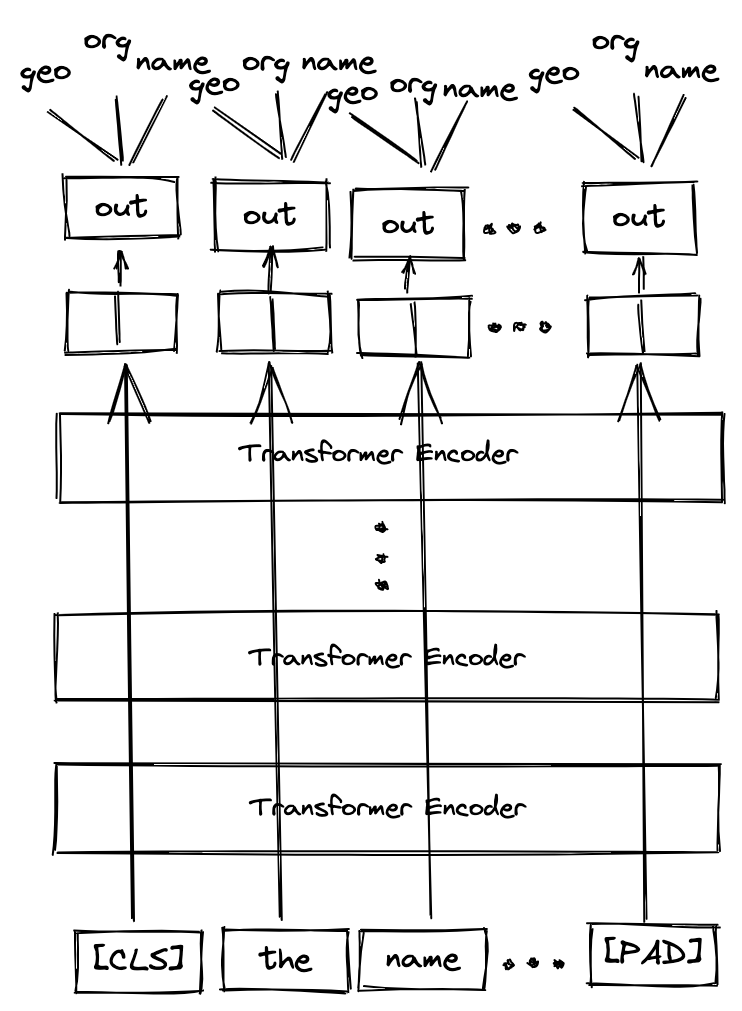

## 3.1.4 練習：訓練模型
執行以下程式碼，進行訓練。


In [11]:
###################################################################################
##### 定義必要的處理函式

import torch
from transformers import BertForTokenClassification

def align_label(texts, labels, tokenizer):
    tokenized_inputs = tokenizer(texts, padding='max_length', max_length=512, truncation=True)

    word_ids = tokenized_inputs.word_ids()

    previous_word_idx = None
    label_ids = []

    for word_idx in word_ids:

        if word_idx is None:
            label_ids.append(-100)

        elif word_idx != previous_word_idx:
            try:
                label_ids.append(labels_to_ids[labels[word_idx]])
            except:
                label_ids.append(-100)
        else:
            try:
                label_ids.append(labels_to_ids[labels[word_idx]] if label_all_tokens else -100)
            except:
                label_ids.append(-100)
        previous_word_idx = word_idx

    return label_ids

class DataSequence(torch.utils.data.Dataset):

    def __init__(self, df):
        self.tokenizer = BertTokenizerFast.from_pretrained(USE_PRETRAINED)

        lb = [i.split() for i in df['y'].values.tolist()]
        txt = df['x'].values.tolist()
        self.texts = [self.tokenizer(str(i),
                               padding='max_length', max_length = 512, truncation=True, return_tensors="pt") for i in txt]
        self.labels = [align_label(i,j, self.tokenizer) for i,j in zip(txt, lb)]

    def __len__(self):

        return len(self.labels)

    def get_batch_data(self, idx):

        return self.texts[idx]

    def get_batch_labels(self, idx):

        return torch.LongTensor(self.labels[idx])

    def __getitem__(self, idx):

        batch_data = self.get_batch_data(idx)
        batch_labels = self.get_batch_labels(idx)

        return batch_data, batch_labels


class BertMyModel(torch.nn.Module):

    def __init__(self, name_pretrained, num_labels):

        super(BertMyModel, self).__init__()
        self.bert = BertForTokenClassification.from_pretrained(name_pretrained, num_labels=num_labels)

    def forward(self, input_id, mask, label):

        output = self.bert(input_ids=input_id, attention_mask=mask, labels=label, return_dict=False)

        return output

In [12]:
from torch.utils.data import DataLoader
from torch.optim import SGD
from tqdm import tqdm

def train_loop(model, df_train, df_val):

    train_dataset = DataSequence(df_train)
    val_dataset = DataSequence(df_val)

    train_dataloader = DataLoader(train_dataset, num_workers=4, batch_size=1, shuffle=True)
    val_dataloader = DataLoader(val_dataset, num_workers=4, batch_size=1)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    optimizer = SGD(model.parameters(), lr=LEARNING_RATE)

    if use_cuda:
        model = model.cuda()

    best_acc = 0
    best_loss = 1000

    for epoch_num in range(EPOCHS):

        total_acc_train = 0
        total_loss_train = 0

        model.train()

        for train_data, train_label in tqdm(train_dataloader):

            train_label = train_label[0].to(device)
            mask = train_data['attention_mask'][0].to(device)
            input_id = train_data['input_ids'][0].to(device)

            optimizer.zero_grad()
            loss, logits = model(input_id, mask, train_label)

            logits_clean = logits[0][train_label != -100]
            label_clean = train_label[train_label != -100]

            predictions = logits_clean.argmax(dim=1)

            acc = (predictions == label_clean).float().mean()
            total_acc_train += acc
            total_loss_train += loss.item()

            loss.backward()
            optimizer.step()

        model.eval()

        total_acc_val = 0
        total_loss_val = 0

        for val_data, val_label in val_dataloader:

            val_label = val_label[0].to(device)
            mask = val_data['attention_mask'][0].to(device)

            input_id = val_data['input_ids'][0].to(device)

            loss, logits = model(input_id, mask, val_label)

            logits_clean = logits[0][val_label != -100]
            label_clean = val_label[val_label != -100]

            predictions = logits_clean.argmax(dim=1)

            acc = (predictions == label_clean).float().mean()
            total_acc_val += acc
            total_loss_val += loss.item()

        val_accuracy = total_acc_val / len(df_val)
        val_loss = total_loss_val / len(df_val)

        print(
            f'Epochs: {epoch_num + 1} | Loss: {total_loss_train / len(df_train): .3f} | Accuracy: {total_acc_train / len(df_train): .3f} | Val_Loss: {total_loss_val / len(df_val): .3f} | Accuracy: {total_acc_val / len(df_val): .3f}')

def evaluate(model, df_test):

    test_dataset = DataSequence(df_test)

    test_dataloader = DataLoader(test_dataset, num_workers=4, batch_size=1)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    total_acc_test = 0.0

    for test_data, test_label in test_dataloader:

        test_label = test_label[0].to(device)
        mask = test_data['attention_mask'][0].to(device)
        input_id = test_data['input_ids'][0].to(device)

        loss, logits = model(input_id, mask, test_label.long())

        logits_clean = logits[0][test_label != -100]
        label_clean = test_label[test_label != -100]

        predictions = logits_clean.argmax(dim=1)

        acc = (predictions == label_clean).float().mean()
        total_acc_test += acc

    val_accuracy = total_acc_test / len(df_test)
    print(f'Test Accuracy: {total_acc_test / len(df_test): .3f}')


####### 不檢查標記...... ##################
def predict(model, test_list):

    test = DataSequence(test_list)
    test_dataloader = DataLoader(test, num_workers=4, batch_size=1)
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    if use_cuda:
        model = model.cuda()

    pred_label = np.array([]).astype('int')

    for test_data, test_label in test_dataloader:
        #test_label = test_label[0].to(device)  #test_label is dummy value
        mask = test_data['attention_mask'][0].to(device)
        input_id = test_data['input_ids'][0].to(device)

        loss, logits = model(input_id, mask, test_label.long())

        logits_clean = logits[0][test_label != -100]
        label_clean = test_label[test_label != -100]

        predictions = logits_clean.argmax(dim=1)
        pred_label = np.append(pred_label, predictions)

    return pred_label


In [15]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2
EPOCHS = 10
LEARNING_RATE = 1e-05
MAX_GRAD_NORM = 10

num_len = len(unique_labels)     # only O, B, I

model = BertMyModel(USE_PRETRAINED, num_len)
train_loop(model, df_train, df_val)

# CPU 模式：約需???小時
# GPU 模式：約需2~3小時

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


KeyboardInterrupt: 

In [16]:
# 使用 BertForTokenClassification

#model = BertForTokenClassification.from_pretrained(USE_PRETRAINED)

#inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
#labels = torch.tensor([1] * inputs["input_ids"].size(1)).unsqueeze(0)  # Batch size 1

#with torch.no_grad():
#    logits = model(**inputs).logits

#predicted_token_class_ids = logits.argmax(-1)

# Note that tokens are classified rather then input words which means that
# there might be more predicted token classes than words.
# Multiple token classes might account for the same word
#predicted_tokens_classes = [model.config.id2label[t.item()] for t in predicted_token_class_ids[0]]
#print(predicted_tokens_classes)

# 這個模型，預設裡面有哪幾類
#model.eval()

結果如何？您的記錄應該包含以下內容：

(1) 混淆矩陣 Confusion matrix


---
# 3.3 評估

若要在測試集上評估模型，就必須指定 `.nemo` 訓練模型的位置。每個實驗都會在有 `nemo_experiments` 時間戳記的目錄下執行結果。繼續往下探究，可以找到 `checkpoints` 資料夾，最後的 `token_classification_model.nemo` 就在其中。下一個儲存格會用一些 Python 邏輯來擷取模型清單，並找出最新的模型。

您可以使用以下幾種方式，在測試集上執行評估：
1. 使用相同的覆寫執行 `token_classification_evaluate.py`，再加上 `pretrained_model` 的覆寫，且必須為 `.nemo` 格式。
        
2. 儲存已訓練模型的檢查點並執行 NeMo 方法來評估測試集，以便具現化模型。<br>
   我們將會逐步說明此方法。

---
（Maty note: 將改為<font color='red'>「儲存模型」／「匯入模型」的範例</font>）


使用 `evaluate_from_file` 方法，運用測試集評估模型。將 `add_confusion_matrix` 設定為 True，以視覺化方式呈現模型的表現。

In [ ]:
evaluate(model, df_test)

---
# 3.4 推論
若要在查詢清單中執行推論，請使用已載入 `add_predictions` 方法的相同模型。

In [ ]:
queries = ["Clustering of missense mutations in the ataxia - telangiectasia gene in a sporadic T - cell leukaemia . ",
    "Ataxia - telangiectasia ( A - T ) is a recessive multi - system disorder caused by mutations in the ATM gene at 11q22 - q23 ( ref . 3 ) . ",
    "The risk of cancer , especially lymphoid neoplasias , is substantially elevated in A - T patients and has long been associated with chromosomal instability . ",
    "By analysing tumour DNA from patients with sporadic T - cell prolymphocytic leukaemia ( T - PLL ) , a rare clonal malignancy with similarities to a mature T - cell leukaemia seen in A - T , we demonstrate a high frequency of ATM mutations in T - PLL . ",
    "In marked contrast to the ATM mutation pattern in A - T , the most frequent nucleotide changes in this leukaemia were missense mutations . ",
    "These clustered in the region corresponding to the kinase domain , which is highly conserved in ATM - related proteins in mouse , yeast and Drosophila . ",
    "The resulting amino - acid substitutions are predicted to interfere with ATP binding or substrate recognition . ",
    "Two of seventeen mutated T - PLL samples had a previously reported A - T allele . ",
    "In contrast , no mutations were detected in the p53 gene , suggesting that this tumour suppressor is not frequently altered in this leukaemia . ",
    "Occasional missense mutations in ATM were also found in tumour DNA from patients with B - cell non - Hodgkins lymphomas ( B - NHL ) and a B - NHL cell line . "
          ]

In [ ]:
#results = model.add_predictions(queries, output_file='predictions.txt')


In [ ]:
!cat predictions.txt